# Quantum Capacitance in 2D Materials

## Differential Quantum Capacitance
The **differential quantum capacitance** is given by:

$$
C_{diff} = e^2 \int_{-\infty}^{+\infty} D(E) F_T (E - e\phi_C) dE
$$

where \(F_T(E)\) is the **thermal spreading function**.

## Thermal Spreading Function
The thermal spreading function, which accounts for temperature effects, is:

$$
F_T(E) = (4 k_B T)^{-1} \operatorname{sech}^2 \left( \frac{E}{2 k_B T} \right)
$$

- \(k_B\): Boltzmann's constant.  
- \(T\): Temperature.  



Quantum capacitance values saved in quantum_capacitance.dat


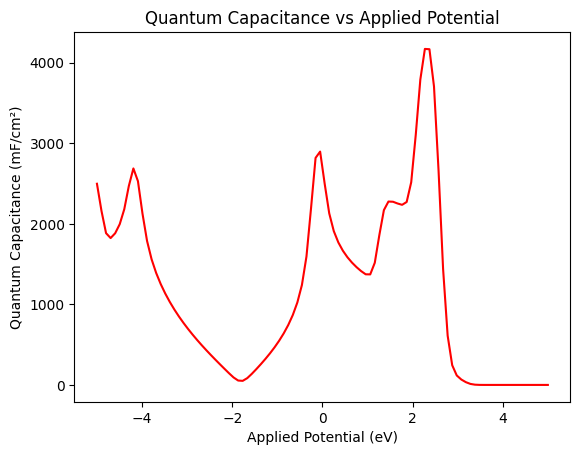

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def read_input(filename):
    data = np.loadtxt(filename, unpack=True)
    return data[0], data[1], data[2]

def calculate_tdos(up, down):
    return abs(up) + abs(down)

def FT_Func(E, phi, kbT):
    etherm = (E - phi) / (2 * kbT)
    etherm_masked = np.ma.masked_outside(etherm, -330, 330)
    return 2 / (np.cosh(2 * etherm_masked) + 1), etherm_masked.mask

def integrate_qc(E, TDOS, phi, kbT, e_charge, S, M, uF_per_cm2_constant, F_per_gram_constant):
    FT, mask = FT_Func(E, phi, kbT)
    TDOS_masked = np.ma.masked_array(TDOS, mask=mask)
    E_masked = np.ma.masked_array(E, mask=mask)
    
    integral = np.trapz(FT * TDOS_masked, x=E_masked) * e_charge**2 / (4 * kbT)
    integral_mF_per_cm2 = integral * uF_per_cm2_constant / S
    integral_F_per_gram = integral * F_per_gram_constant / M
    
    return integral_mF_per_cm2, integral_F_per_gram

def save_qc_values(phispace, qc_values, filename="quantum_capacitance.dat"):
    with open(filename, "w") as f:
        f.write("#Phi(eV)    QC(micro-F cm^-2)\n")
        for phi, qc in zip(phispace, qc_values):
            f.write(f"{phi}     {qc}\n")
    print(f"Quantum capacitance values saved in {filename}")

def main(filename, phi_min, phi_max, num_points, temperature, surface_area, mass):
    e_charge = 1.602176634e-19
    kb_eV = 8.617333262e-5
    kbT = temperature * kb_eV
    uF_per_cm2_constant = 6.241418e40
    F_per_gram_constant = 3.75867e42
    filename = 'dos.dat'

    E, up, down = read_input(filename)
    TDOS = calculate_tdos(up, down)
    phispace = np.linspace(phi_min, phi_max, num_points)    
    phis = np.linspace(phi_min, phi_max, num_points)
    qc_values = []
    for phi in phis:
        qc_value, _ = integrate_qc(E, TDOS, phi, kbT, e_charge, surface_area, mass, uF_per_cm2_constant, F_per_gram_constant)
        qc_values.append(qc_value)

    save_qc_values(phispace, qc_values)    
    plt.plot(phis, qc_values, c='r')
    plt.xlabel("Applied Potential (eV)")
    plt.ylabel("Quantum Capacitance (mF/cm²)")
    plt.title("Quantum Capacitance vs Applied Potential")
    plt.show()


main("dos_data.txt", -5.0, 5.0, 100, 300.0, 5.241, 24.0)
